In [1]:
library(cowplot)
library(ggplot2)
library(data.table)
theme_set(theme_bw())

In [2]:
# tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# # Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
# correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

tools=c('lyrebird', 'metaphlan4', 'phanta')
correct_taxonomy_tools = c('lyrebird')

publication_names = data.table(
    tool = tools,
    publication_name = c('Lyrebird', 'MetaPhlAn4', 'Phanta')
    # publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
setwd('~/rossenzhao/lyrebird-benchmarking/4_known_species_marine/')
base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
lyrebird,marine0
lyrebird,marine1
lyrebird,marine2


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
lyrebird,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
lyrebird,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
lyrebird,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 1820    7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
lyrebird,marine0,kingdom,Bray-Curtis distance,0
lyrebird,marine0,phylum,Bray-Curtis distance,0
lyrebird,marine0,class,Bray-Curtis distance,0


[1] 910   5

In [9]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 70  5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
lyrebird,marine0,kingdom,Bray-Curtis distance,0.000000e+00
lyrebird,marine0,phylum,Bray-Curtis distance,0.000000e+00
lyrebird,marine0,class,Bray-Curtis distance,0.000000e+00
lyrebird,marine0,order,Bray-Curtis distance,9.199395e-02
lyrebird,marine0,family,Bray-Curtis distance,1.224216e-01
lyrebird,marine0,genus,Bray-Curtis distance,1.507573e-01
lyrebird,marine0,species,Bray-Curtis distance,3.630033e-01
lyrebird,marine1,kingdom,Bray-Curtis distance,0.000000e+00
lyrebird,marine1,phylum,Bray-Curtis distance,9.872581e-05


In [10]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
lyrebird,marine0,kingdom,Bray-Curtis distance,0
lyrebird,marine0,phylum,Bray-Curtis distance,0
lyrebird,marine0,class,Bray-Curtis distance,0


In [11]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
lyrebird,0.0917273


In [12]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


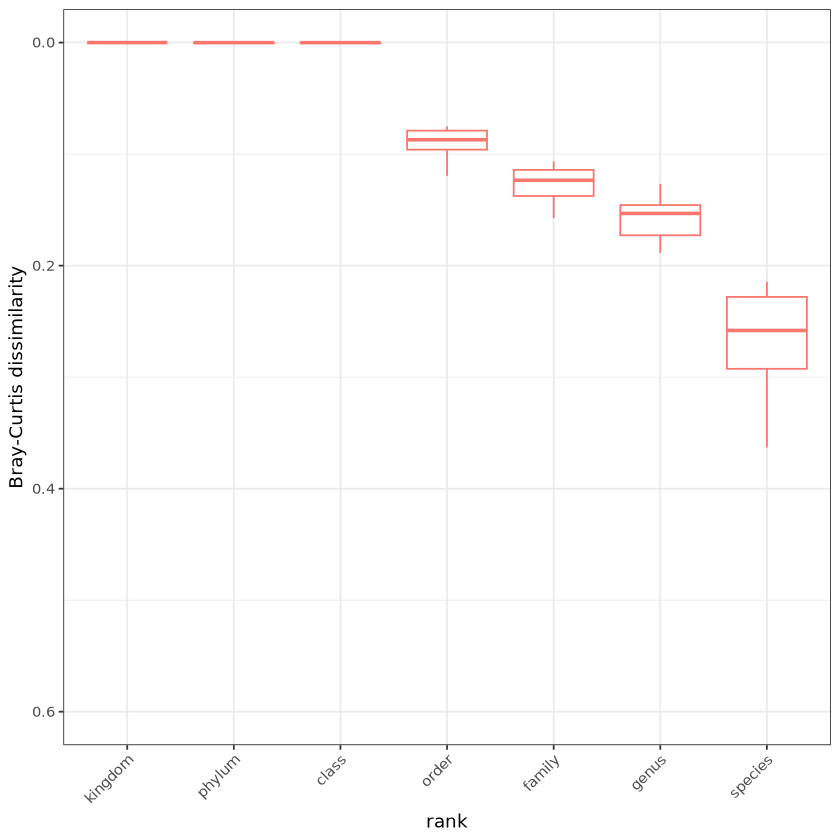

In [13]:
# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
# qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + theme(legend.position = "none")


In [14]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='lyrebird', V1] - means[tool!='lyrebird', min(V1)]

tool,V1
<fct>,<dbl>
lyrebird,0.2687577


Warning message in min(V1):
“no non-missing arguments to min; returning Inf”


[1] -Inf

In [15]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

Warning message in melt.data.table(counts_to_truths, id.vars = NULL, variable.name = "tool", :
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns []. Consider providing at least one of 'id' or 'measure' vars in future.”


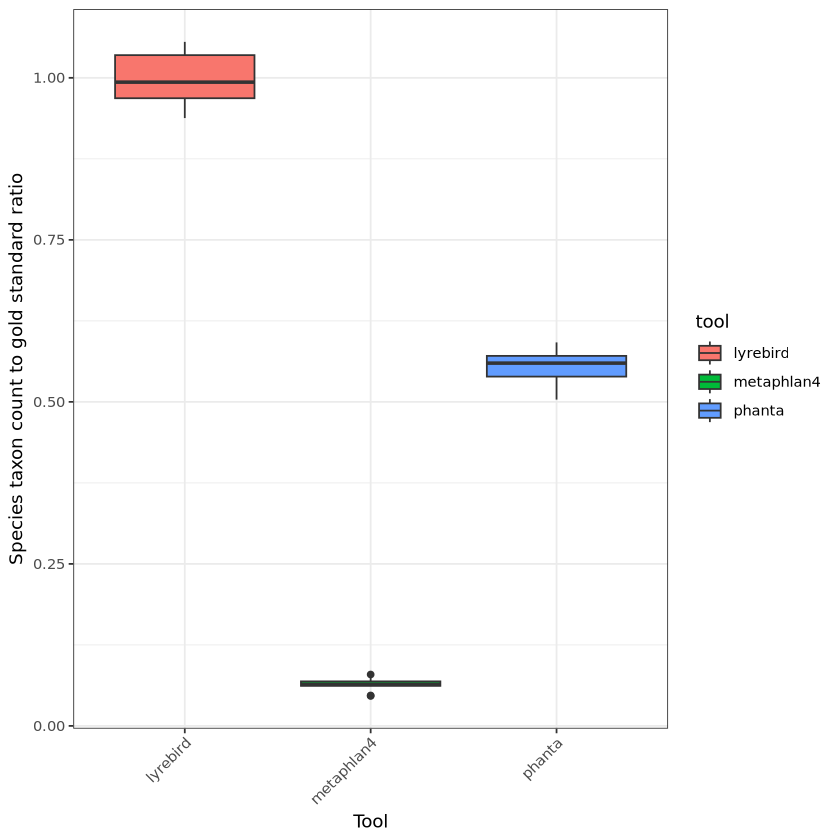

In [16]:
# tool comparison of species taxon counts to gold standard
counts_to_truths = fread("species_count_to_truths.csv")
# value of 1 means same number of species as gold standard
# counts_to_truths has each column (3 columns) as a tool, and each row as a sample
# column labels are lyrebird, metaphlan4, phanta
# example row 1 is 1.0, 0.5, 0.5
# plot boxplot of each tool's species taxon ratio to gold standard
counts_to_truths_long <- melt(counts_to_truths, id.vars = NULL, variable.name = "tool", value.name = "value")

# Create the boxplot
ggplot(counts_to_truths_long, aes(x = tool, y = value, fill = tool)) +
  geom_boxplot() +
  labs(y = "Species taxon count to gold standard ratio", x = "Tool") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Runtime comparison

In [17]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [18]:
thread_numbers = as.character(c(1,8,32))
# thread_numbers = as.character(c(1))

In [19]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<fct>,<fct>
lyrebird,1,marine0
metaphlan4,1,marine0
phanta,1,marine0


In [20]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/rossenzhao/lyrebird-benchmarking/4_known_species_marine"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lyrebird,1,marine0,419.0636,0:06:59,810.17,3090.45,792.99,794.34,46.3,67.66,53.13,148.77
metaphlan4,1,marine0,253.0019,0:04:13,19341.13,20985.61,19299.65,19314.64,0.0,68.23,119.57,101.97
phanta,1,marine0,27.5050,0:00:27,30997.26,31406.54,30987.72,30988.70,0.0,18.78,53.16,14.81


In [21]:
plot1 = qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [22]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
plot2 = qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [23]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
plot3 = qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

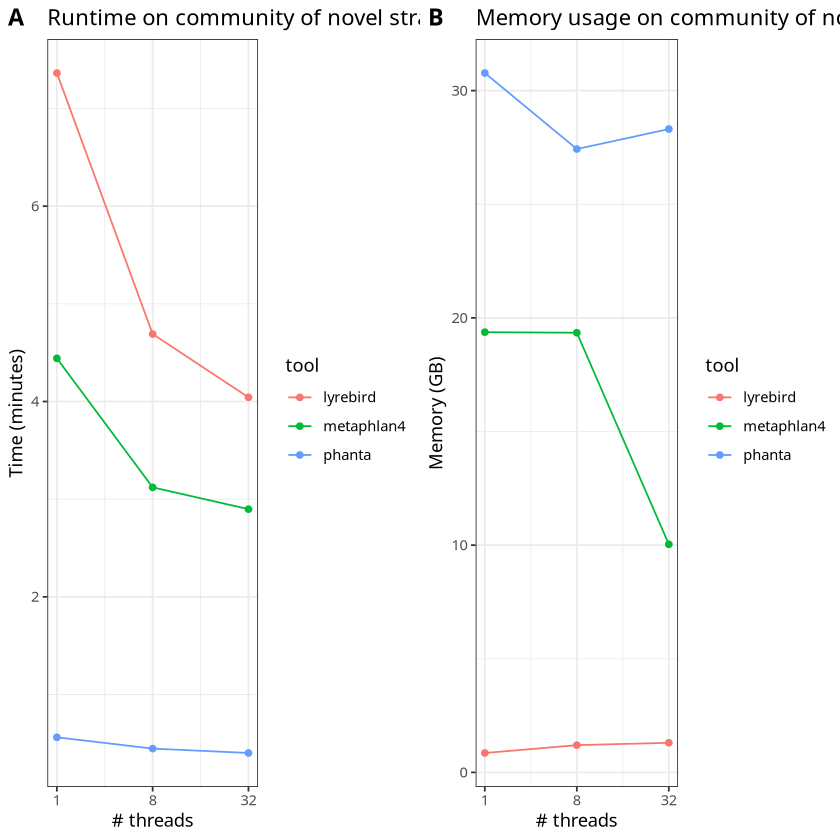

In [24]:
plot_grid(plot2, plot3, labels="AUTO")


# Full set of stats of each method

In [17]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1 = s1[tool %in% correct_taxonomy_tools]
s1[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
# s1[1:3]
s1
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lyrebird,kingdom,0.0000000000,1.0000000,1.0000000,0.0,0.0,1.0000000,0.000000000,1.0000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lyrebird,phylum,0.0007586124,0.9000000,0.9333333,0.2,0.0,0.9000000,0.001514361,1.0000000,0.00236569,0.002327268,0.9992446,1.2,1.2,NaN,NaN,NaN,NaN
Lyrebird,class,0.0007586124,0.9000000,0.9333333,0.2,0.0,0.9000000,0.001514361,1.0000000,0.00236569,0.002327268,0.9992446,1.2,1.2,NaN,NaN,NaN,NaN
Lyrebird,order,0.0954843018,0.9271272,0.9518369,6.0,1.7,0.9085368,0.190880511,0.9781383,3.24429605,0.746346643,0.9992446,77.5,75.8,NaN,NaN,NaN,NaN
Lyrebird,family,0.1347619801,0.9378977,0.9548453,16.7,7.0,0.9137340,0.268198029,0.9725858,4.61532803,0.833701181,0.9906358,254.7,247.7,NaN,NaN,NaN,NaN
Lyrebird,genus,0.1689274365,0.9222768,0.9246325,35.0,32.2,0.8599848,0.331025598,0.9271976,5.11558273,0.840913694,0.9604317,441.3,409.1,NaN,NaN,NaN,NaN
Lyrebird,species,0.2721374163,0.7938405,0.7948937,97.8,95.1,0.6599532,0.505483556,0.7964739,4.69663752,0.764928788,0.8590443,466.7,371.6,NaN,NaN,NaN,NaN
Lyrebird,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2066.4,0.584011,1.298616,0.00805016


# Relationship between relative abundance and accuracy

In [18]:
base = base_dir #'/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains/full_run1/checkout/1_novel_strains/'
# base = './'

truth_profiles = data.table(community=communities)
truth_profiles2 = truth_profiles[, fread(paste(base,'/truths/',community,'.condensed',sep='')), by=community]
truth_profiles2[, sample := NULL]
setnames(truth_profiles2, 'coverage', 'true_coverage')

tool_profiles = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(tool_profiles, c('tool','community'))
tool_profiles2 = tool_profiles[, fread(paste(base,'/output_',tool,'/',tool,'/',community,'.profile',sep='')), by=list(tool,community)]
tool_profiles2[, sample := NULL]
setnames(tool_profiles2, 'coverage', 'tool_coverage')
tool_profiles2[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3 = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 's__']
)
tool_profiles3[tool=='kraken'][1:5]
# cartesian product so the all = T works for each tool
community_tool = data.table(expand.grid(tools, communities))
setnames(community_tool, c('tool','community'))
truth_profiles3 = merge(truth_profiles2, community_tool, all=T, allow.cartesian=T)
# truth_profiles3

m = merge(truth_profiles3, tool_profiles3, by=c('taxonomy','community','tool'), all=T)

m[is.na(tool_coverage), tool_coverage := 0]
m[is.na(true_coverage), true_coverage := 0]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


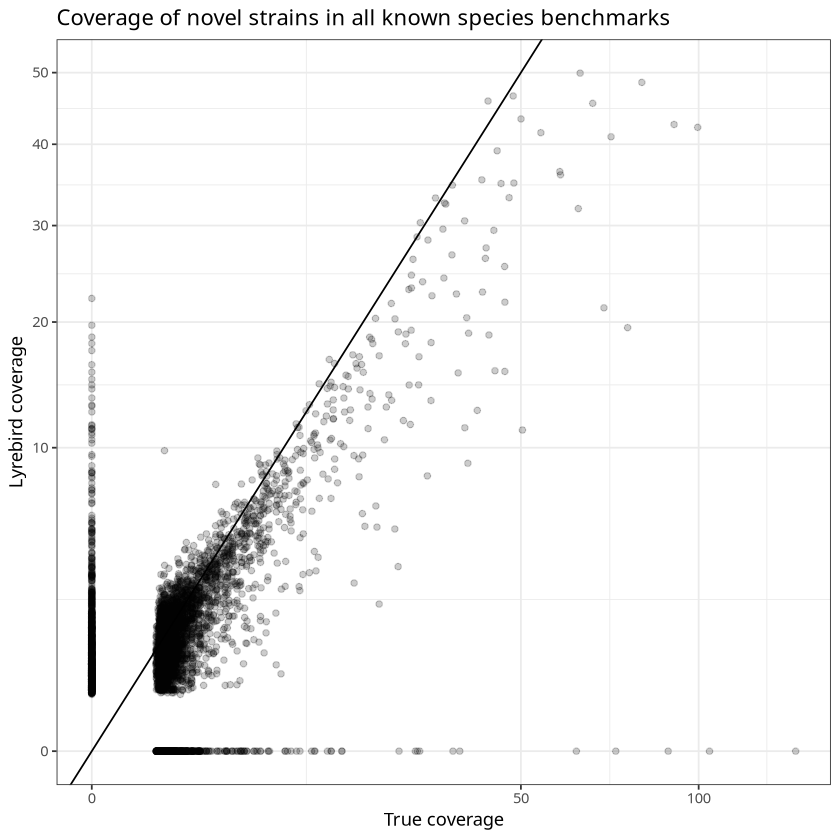

In [41]:
# Just for SingleM
qplot(data=m[tool=='lyrebird' & tool_coverage < 50][grep('s__',taxonomy)], true_coverage, tool_coverage, geom='point', xlab='True coverage', ylab='Lyrebird coverage', main='Coverage of species in all non-representative species benchmarks', alpha=I(1/5)) + geom_abline(intercept=0, slope=1)+scale_x_sqrt()+scale_y_sqrt()

In [42]:
m[tool=='kraken'][grep('s__',taxonomy)][community=='marine6'][order(-tool_coverage)][1:3]

taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA


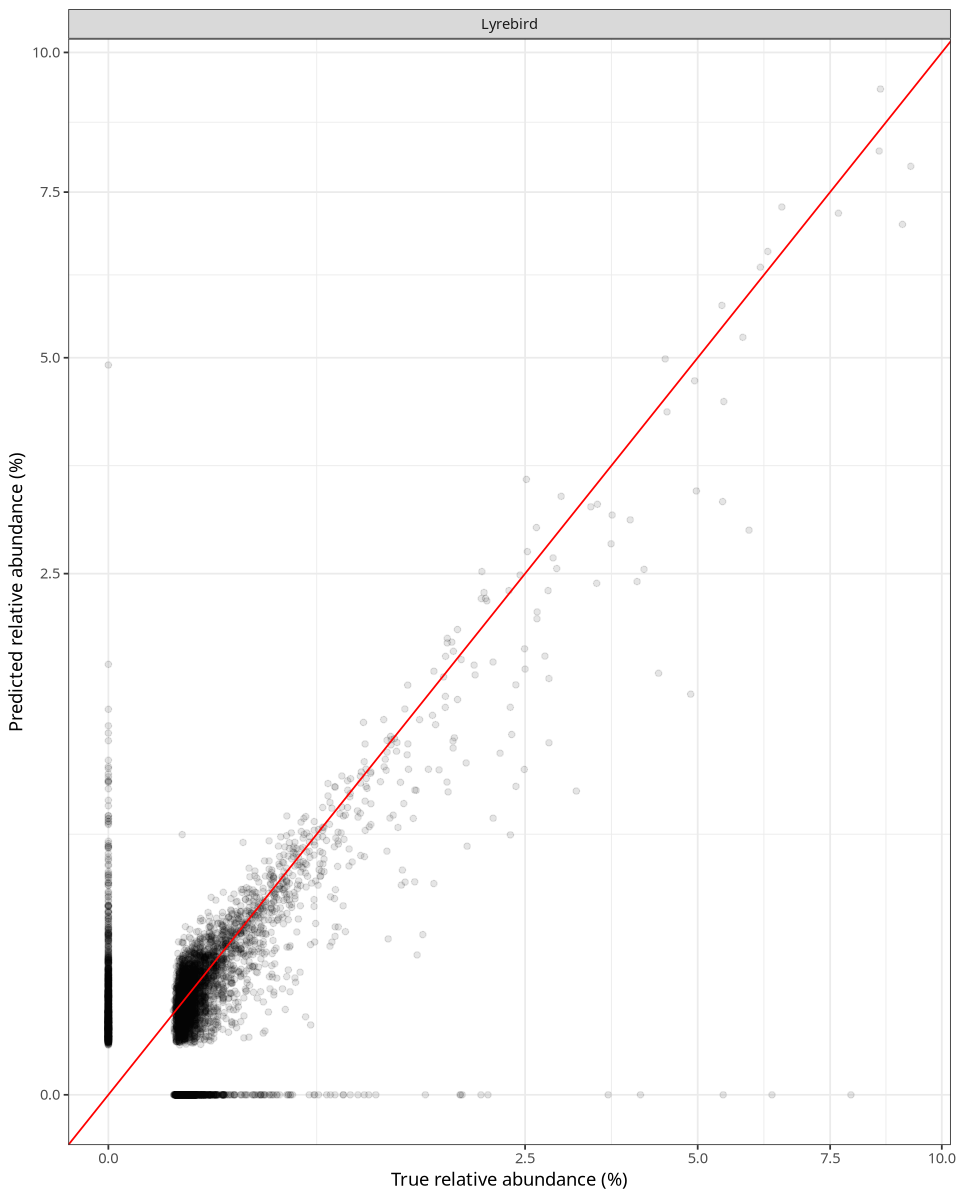

In [43]:
# All tools
# First convert to relabund
m[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m = m[tool %in% correct_taxonomy_tools]
m[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m[grep('s__',taxonomy)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [31]:
# What's with the 20+ coverage genome?

# marine0 = fread(paste(base,'truths/marine0.condensed',sep=''))
# marine0[, sample := 'marine0']
# setnames(marine0, 'coverage', 'true_coverage')
# singlem_marine0 = fread(paste(base,'output_singlem/singlem/marine0.profile',sep=''))
# setnames(singlem_marine0, 'coverage', 'singlem_coverage')
# singlem_marine0[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]
# # singlem_marine0[grep('s__',taxonomy)][1:3]

# m[true_coverage > 20 & singlem_coverage ==0]
# singlem_marine0[grep('g__Pseudomonas_E',taxonomy)]
# # => So it backed off to species level for some reason. Unsure why.

In [32]:
# Fraction of genomes which were missed at each binned coverage levels
# m[, .(missed = sum(singlem_coverage==0)/.N*100, .N), by=.(cut(true_coverage, breaks=c(0,2,4,6,8,10,20,40,1000)))][order(cut)]

In [44]:
# How well does genus level rescue some of the missing genomes? First need to remake the table with genus level, annoying since kraken profiles are filled, when the rest aren't.

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3_genus = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 'g__']
)
tool_profiles3_genus[tool=='kraken'][1:5]

m_genus = merge(truth_profiles3, tool_profiles3_genus, by=c('taxonomy','community','tool'), all=T)

m_genus[is.na(tool_coverage), tool_coverage := 0]
m_genus[is.na(true_coverage), true_coverage := 0]

m_genus[1:3]

m_genus[, genus_and_up := gsub(';s__.*','',taxonomy)]

# m[grep('g__',taxonomy)][1:10]
m2_genus = m_genus[, .(tool_coverage=sum(tool_coverage), true_coverage=sum(true_coverage)), by=.(community, genus_and_up, tool)]

m2_genus[grep('g__',genus_and_up)][tool=='kraken' & true_coverage > 0][1:3]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Viruses,marine6,lyrebird,0.00000,12.19
d__Viruses;p__Dividoviricota|Preplasmiviricota;c__Laserviricetes|Tectiliviricetes;o__Halopanivirales;f__Matshushitaviridae;g__Hukuchivirus;s__Hukuchivirus_P2377,marine7,lyrebird,1.33830,0.00
d__Viruses;p__Dividoviricota|Preplasmiviricota;c__Laserviricetes|Tectiliviricetes;o__Halopanivirales;f__novel_family_0_of_Halopanivirales;g__novel_genus_0_of_noRef_of_novel_family_0_of_Halopanivirales;s__IMGVR_UViG_2891705458_000001,marine3,lyrebird,1.22743,0.00


community,genus_and_up,tool,tool_coverage,true_coverage
<fct>,<chr>,<fct>,<dbl>,<dbl>
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA


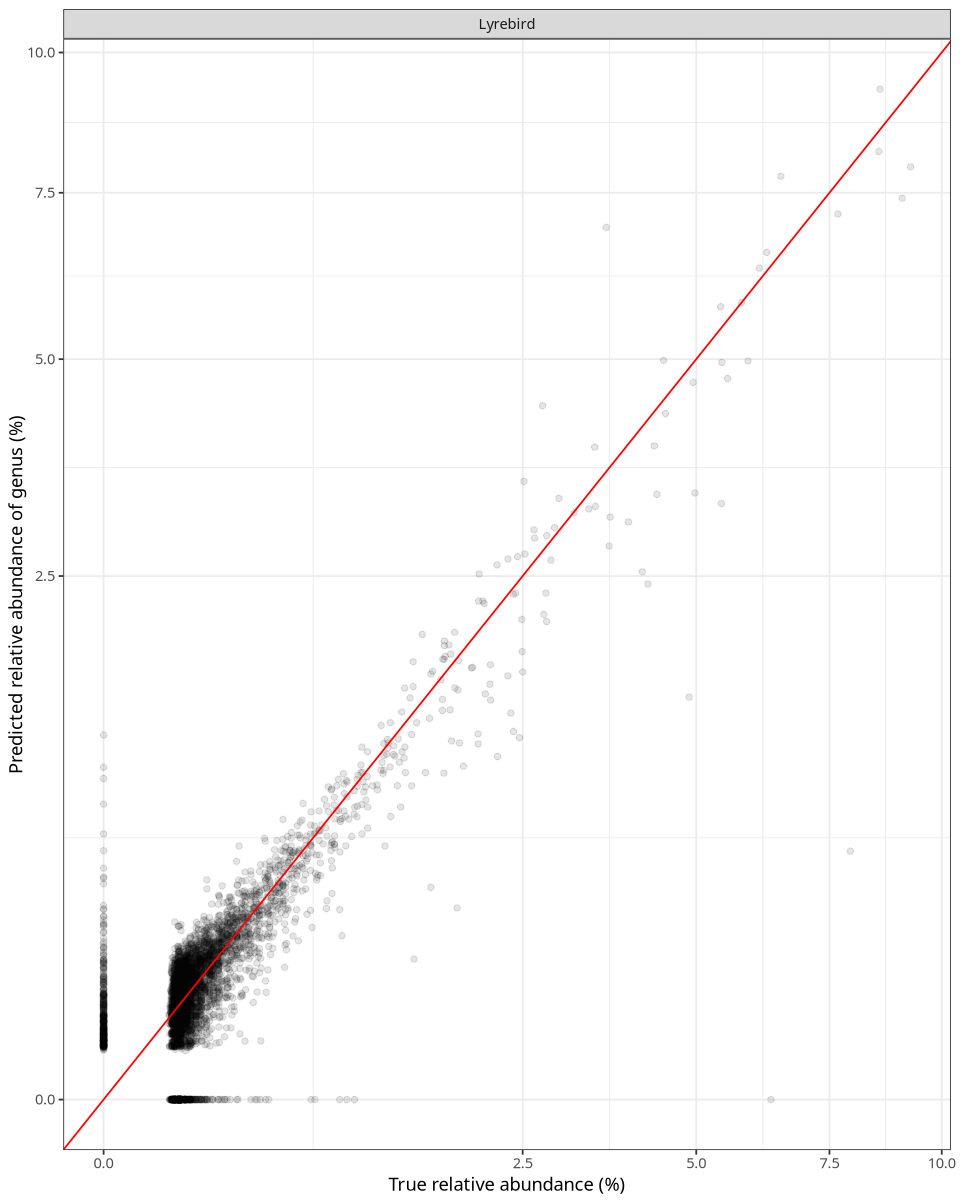

In [45]:
m2_genus[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m2_genus[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m2_genus = m2_genus[tool %in% correct_taxonomy_tools]
m2_genus[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m2_genus[grep('g__',genus_and_up)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance of genus (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


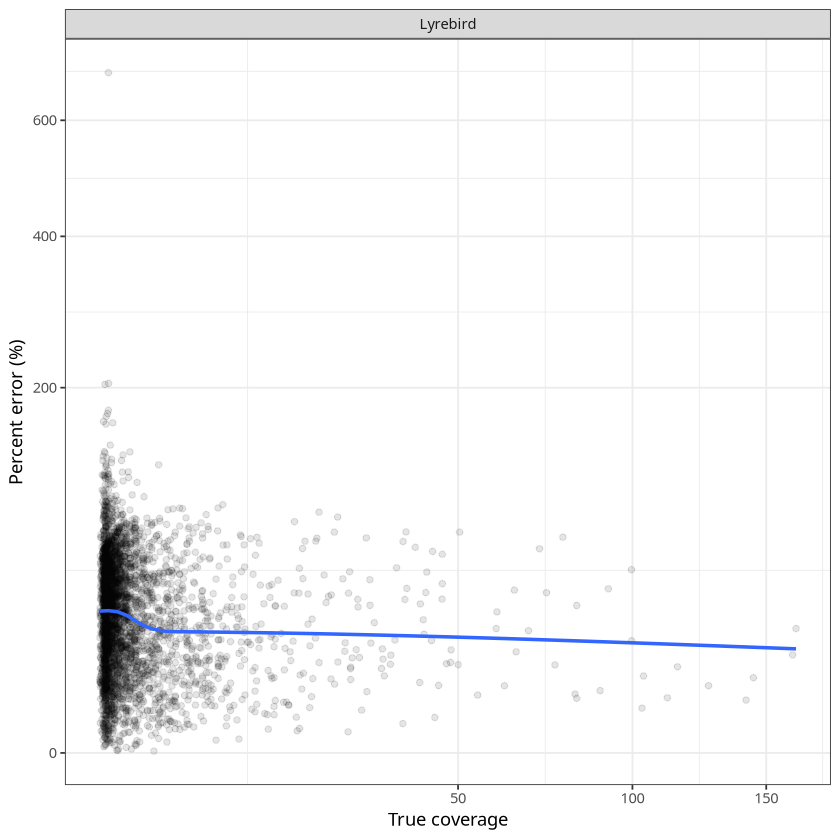

In [46]:
# Percent error at the species level for each tool
m_error = m[true_coverage>0 & tool_coverage>0]
m_error[, error := abs(true_coverage_relabund - tool_coverage_relabund)/true_coverage_relabund*100]

qplot(data=m_error, true_coverage, error, geom='point', xlab='True coverage', ylab='Percent error (%)', alpha=I(1/10))+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2)+geom_smooth(se=F)

# What fraction of singlem profiles are assigned to the species level?

In [48]:
# m
assigned = m[tool2=='Lyrebird'][,sum(.SD[grep('s__',taxonomy)]$tool_coverage_relabund),by=community]
assigned
mean(assigned$V1)
sd(assigned$V1)

community,V1
<fct>,<dbl>
marine6,79.83752
marine7,84.29709
marine3,86.16581
marine1,87.67280
marine0,84.98594
marine5,88.97745
marine9,85.93376
marine4,85.93973
marine8,87.29044


[1] 85.90443

[1] 2.559418

# How many species are in each gold standard?

In [49]:
coverages = data.table(number=0:9)
coverages2 = coverages[, fread(paste('coverage_definitions/coverage',number,'.tsv',sep='')), by=number]
setnames(coverages2, c('number','genome','coverage'))
mean(coverages2[grep('Otu',genome)][coverage>0][,.N,by=number]$N)
coverages2[grep('Otu',genome)][coverage>0]

[1] 469.4

number,genome,coverage
<int>,<chr>,<dbl>
0,Otu520.0,2.12834
0,Otu634.0,1.83878
0,Otu483,2.42345
0,Otu2487,1.56681
0,Otu2446,1.33722
0,Otu980,3.43963
0,Otu1219,1.34402
0,Otu2448,2.10658
0,Otu489.0,1.57037
